# Spotify Web Scrapping w Python

### Scrapping from wikipedia

In [2]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Access HTML
url = 'https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify'
headers = {'User-Agent': 'MyWebScrapper/1.0'}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
soup

<!DOCTYPE html>

<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-available" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of Spotify streaming records - Wikipedia</title>
<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-conten

In [4]:
# Subset desired most streamed songs table
tables = soup.find_all('table', class_='wikitable')
most_streamed_songs = tables[0]
most_streamed_songs.find_all('th')[:5]

[<th>Rank
 </th>,
 <th>Song
 </th>,
 <th>Artist(s)
 </th>,
 <th>Streams<br/>(billions)
 </th>,
 <th>Release date
 </th>]

In [5]:
# Extract table headers into table_headers
header_cells = most_streamed_songs.find_all('tr')[0]
table_headers = [cell.get_text(strip=True) for cell in header_cells if cell.get_text(strip=False) != '\n']
table_headers

['Rank', 'Song', 'Artist(s)', 'Streams(billions)', 'Release date', 'Ref.']

In [6]:
# Extract table rows into a table_data
rows = most_streamed_songs.find_all('tr')[1:]

table_data = []
for row in rows:
    song_name = row.find('th').get_text(strip=True).replace('"', '')
    cells = row.find_all('td')

    tmp_content = [cell.get_text(strip=True) for cell in cells]
    tmp_content.insert(1, song_name)

    table_data.append(tmp_content)
    
table_data[:5]

[['1', 'Blinding Lights', 'The Weeknd', '5.000', '29 November 2019', '[1]'],
 ['2', 'Shape of You', 'Ed Sheeran', '4.528', '6 January 2017', '[2]'],
 ['3',
  'Starboy',
  'The WeekndandDaft Punk',
  '4.063',
  '21 September 2016',
  '[3]'],
 ['4',
  'Someone You Loved',
  'Lewis Capaldi',
  '4.032',
  '8 November 2018',
  '[4]'],
 ['5', 'As It Was', 'Harry Styles', '4.021', '1 April 2022', '[5]']]

In [7]:
df_raw = pd.DataFrame(data=table_data, columns=table_headers)
df_raw.head()

,Rank,Song,Artist(s),Streams(billions),Release date,Ref.
0,1,Blinding Lights,The Weeknd,5.000,29 November 2019,[1]
1,2,Shape of You,Ed Sheeran,4.528,6 January 2017,[2]
2,3,Starboy,The WeekndandDaft Punk,4.063,21 September 2016,[3]
3,4,Someone You Loved,Lewis Capaldi,4.032,8 November 2018,[4]
4,5,As It Was,Harry Styles,4.021,1 April 2022,[5]


### Data preprocessing and analysis

In [8]:
df_baking = df_raw.copy()
df_baking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Rank               101 non-null    object
 1   Song               100 non-null    object
 2   Artist(s)          100 non-null    object
 3   Streams(billions)  100 non-null    object
 4   Release date       100 non-null    object
 5   Ref.               100 non-null    object
dtypes: object(6)
memory usage: 4.9+ KB


In [9]:
display(df_baking[df_baking.isna().any(axis=1)]) # This is the last line of the wikipedia table, thus will be dropped
df_baking = df_baking.dropna()

,Rank,Song,Artist(s),Streams(billions),Release date,Ref.
100,As of 31 August 2025,None,None,None,None,None


In [10]:
df_baking.columns = df_baking.columns.str.lower()

### Cleaning and dtypes

- Rank column can be dropped, since the rank can be implicitly known by sorting the values by # of streams
- Songs $\rightarrow$ str
- Artists $\rightarrow$ category (Only a finite number of artist for different songs)
- Streams $\rightarrow$ Float
- Release date $\rightarrow$ datetime (extract year, so int is just as fine)
- Ref column can be dropped, since they refer to an external link inside wikipedia, which is not useful for analysis

In [11]:
# Drop unnecesary columns
df_baking = df_baking.drop(columns=['rank', 'ref.'])

In [12]:
# Converting str columns
df_baking['song'] = df_baking['song'].astype('str')

# Cleaning artist names 
df_baking["artist(s)"] = df_baking["artist(s)"].str.replace("and", " and ", regex=False)
df_baking["artist(s)"] = df_baking["artist(s)"].str.replace("with", " with ", regex=False)
df_baking['artist(s)'] = df_baking['artist(s)'].astype('category')

In [13]:
# Converting release into date dtype
df_baking['release date'] = pd.to_datetime(df_baking['release date']).dt.year
df_baking['release date']

0     2019
1     2017
2     2016
3     2018
4     2022
      ... 
95    2020
96    2003
97    2017
98    2017
99    1988
Name: release date, Length: 100, dtype: int32

In [64]:
# Streams as float
df_baking['streams(billions)'] = df_baking['streams(billions)'].astype('float') 

In [65]:
df_baking.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   song               100 non-null    object  
 1   artist(s)          100 non-null    category
 2   streams(billions)  100 non-null    float64 
 3   release date       100 non-null    int32   
dtypes: category(1), float64(1), int32(1), object(1)
memory usage: 5.5+ KB


In [66]:
df = df_baking.copy()
df.sample(10)

,song,artist(s),streams(billions),release date
87,Sicko Mode,Travis Scott and Drake,2.437,2018
19,Yellow,Coldplay,3.245,2000
79,The Scientist,Coldplay,2.509,2002
53,The Hills,The Weeknd,2.760,2015
92,Don't Stop Me Now,Queen,2.415,1979
63,Flowers,Miley Cyrus,2.643,2023
96,Numb,Linkin Park,2.393,2003
88,Lean On,Major Lazer with DJ Snake and M∅,2.436,2015
42,Shallow,Lady Gaga and Bradley Cooper,2.866,2018
26,Watermelon Sugar,Harry Styles,3.091,2019


### Visualization

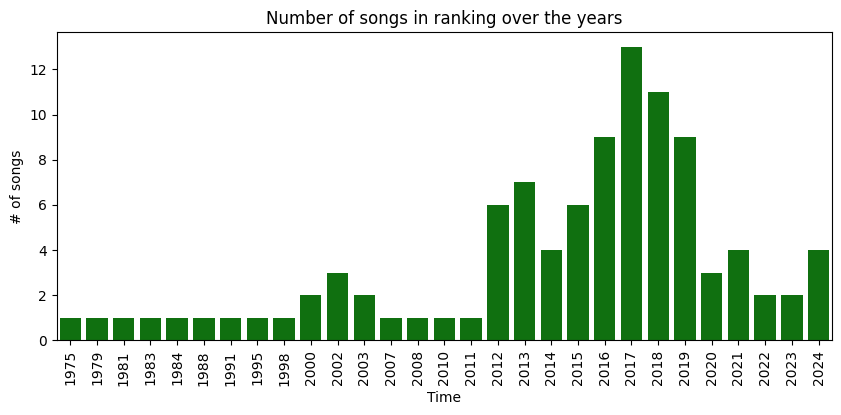

In [67]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='release date', color='g')
plt.xticks(rotation=90)
plt.title('Number of songs in ranking over the years')
plt.xlabel('Time')
plt.ylabel('# of songs')
plt.show()

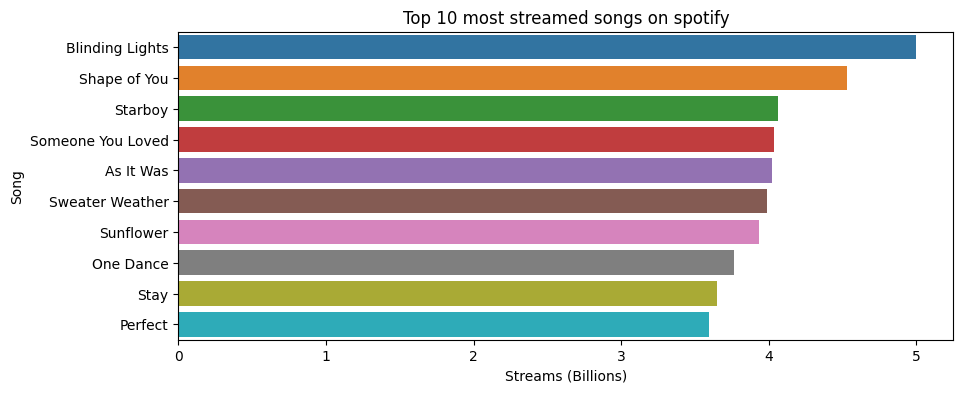

In [136]:
# Streams vs songs
plt.figure(figsize=(10, 4))
sns.barplot(
    data=df.sort_values(by='streams(billions)', ascending=False)[:10], 
    x='streams(billions)', 
    y='song',
    hue='song'
)
plt.xlabel('Streams (Billions)')
plt.ylabel('Song')
plt.title('Top 10 most streamed songs on spotify')
plt.show()

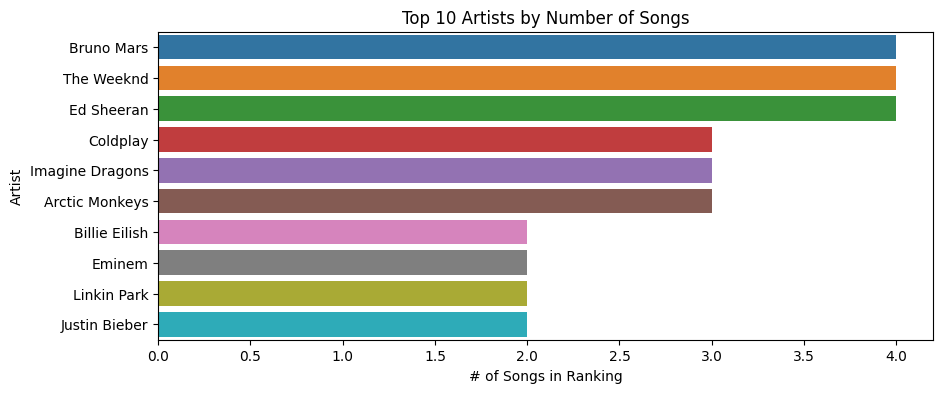

In [135]:
# Artists vs songs in ranking
top10 = df["artist(s)"].value_counts().nlargest(10)

plt.figure(figsize=(10, 4))
sns.barplot(x=top10.values, y=top10.index.tolist(), orient="h", hue=top10.index.tolist())
plt.title("Top 10 Artists by Number of Songs")
plt.xlabel("# of Songs in Ranking")
plt.ylabel("Artist")
plt.show()

### Insights
- Mid/late 2010 were the peak years for songs breaking into the ranking.
- 'Blinding lights' and 'Shape of you' dominate all-time streams, outpacing other songs. 
- 'Bruno Mars', 'The Weeknd' and 'Ed Sheeran' show sustained success throughout their career, by having 4 solo songs in the ranking.